In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../src')

%load_ext autoreload
%autoreload 2

import torch
import torch_geometric
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


from torch_geometric.datasets import TUDataset
from preprocessing import data_transformation
from similarity import calculate_similarity_matrix

from model import GCN
import copy

In [2]:
dataset = TUDataset(root='datasets/', name='MUTAG')
torch.manual_seed(1234)
dataset = dataset.shuffle()

## Preprocessing

#### Split: Train test validation

```train_dataset```: for training model<br/>
```val_dataset```: evaluate model for hyperparameter tunning<br/>
```test_dataset```: testing model after complete training<br/>

In [3]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

## Building Model

In [4]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GINConv
# from torch_geometric.nn import GINConv
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d

from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_add_pool
import torch.nn.functional as F

#### Base

In [5]:
class Base(torch.nn.Module):
    # merging type: o --> complement only, s --> substraction, c --> concatenation
    def __init__(self, dataset, hidden_channels):
        super(Base, self).__init__()
        
        # weight seed
        torch.manual_seed(42)
        nn1 = Sequential(Linear(dataset.num_node_features, hidden_channels), ReLU(), Linear(hidden_channels,hidden_channels))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm1d(hidden_channels)
        
        nn2 = Sequential(Linear(hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels,hidden_channels))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm1d(hidden_channels)
        
        
        # classification layer        
        self.lin = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Embed original
        embedding = F.relu(self.conv1(x, edge_index))
        embedding = self.bn1(embedding)
        embedding = F.relu(self.conv2(embedding, edge_index))
        embedding = self.bn2(embedding)
        
        embedding = global_add_pool(embedding, batch)
        h = self.lin(embedding)
        h = F.relu(h)
        h = F.dropout(h, p=0.3, training=self.training)
        h = self.lin2(h)
        
        return embedding, h

### Experiment Model

In [6]:
from similarity import calculate_similarity_matrix, testt


# AP Clustering
from sklearn.cluster import AffinityPropagation

from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import GINConv, global_add_pool
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d

import torch.nn.functional as F

class Experiment(torch.nn.Module):
    # merging type: o --> complement only, s --> substraction, c --> concatenation
    def __init__(self, dataset, hidden_channels, k = 1):
        super(Experiment, self).__init__()
        
        # save number of subgraphs, default 1
        self.k_subgraph = k
        
        # weight seed
        torch.manual_seed(42)
        nn1 = Sequential(Linear(dataset.num_node_features, hidden_channels), ReLU(), Linear(hidden_channels,hidden_channels))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm1d(hidden_channels)
        
        nn2 = Sequential(Linear(hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels,hidden_channels))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm1d(hidden_channels)
        
        # embeddings for subgraph
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        
        # attention layer
        self.query_layer = Linear(hidden_channels,hidden_channels)
        self.key_layer = Linear(hidden_channels,hidden_channels)
        self.value_layer = Linear(hidden_channels,hidden_channels)
        
        # classification layer
        self.lin = Linear(hidden_channels*2, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch, ptr):
        # Embed original
        # embedding = self.conv1(x, edge_index)
        # embedding = embedding.relu()
        # embedding = self.conv2(embedding, edge_index)
                
        embedding = F.relu(self.conv1(x, edge_index))
        embedding = self.bn1(embedding)
        embedding = F.relu(self.conv2(embedding, edge_index))
        embedding = self.bn2(embedding)
        
        # generate subgraph based on embeddings
        feature_emb = embedding.detach()
        
        subgraph_edge_index, communities, S, batch_communities = self.subgraph_generator(feature_emb, edge_index, batch, ptr)
        
        
        subgraph_embedding = self.conv4(embedding, subgraph_edge_index)
        subgraph_embedding = subgraph_embedding.relu()
        subgraph_embedding = self.conv5(subgraph_embedding, subgraph_edge_index)
        
        # apply readout layer/pooling for each subgraphs
        subgraph_pool_embedding = self.subgraph_pooling(subgraph_embedding, communities, batch, ptr, batch_communities)
        # print(len(subgraph_pool_embedding))
        # apply selective (top k) attention
        topk_subgraph_embedding, topk_indices = self.selectk_subgraph(embedding, subgraph_pool_embedding, self.k_subgraph)
        
        # readout layer for original embedding
        embedding = global_mean_pool(embedding, batch)
                
        combined_embeddings = torch.cat((embedding, topk_subgraph_embedding.view(len(embedding), -1)), 1)
        
        
        # h = F.dropout(combined_embeddings, p=0.3, training=self.training)
        h = self.lin(combined_embeddings)
        h = F.relu(h)
        h = F.dropout(h, p=0.3, training=self.training)
        h = self.lin2(h)
        
        # need to return selected subgraph
        return combined_embeddings, h, S, communities, topk_subgraph_embedding.view(len(embedding), -1), topk_indices
    
    # checked
    def selectk_subgraph(self, embs, sub_embs, k = 1):
        # calculate attention and select top k subgraph
        
        topk_subgraphs_all = []

        for i, (emb, sub_emb) in enumerate(zip(embs, sub_embs)):
            sub = torch.tensor(sub_emb)
            sub = sub.to(torch.float32)

            # transform
            query = self.query_layer(emb)
            key = self.key_layer(sub)
            value = self.value_layer(sub)

            # att score
            attention_score = torch.matmul(query, key.transpose(0,1))
            attention_weight = F.softmax(attention_score, dim=0)
            
            # select topk
            topk_subgraph_embeddings = None
            
            if (k <= len(sub)):
                topk_scores, topk_indices = torch.topk(attention_weight, k)
                topk_subgraph_embeddings = sub[topk_indices]
            else:
                print('too big')
                
            topk_subgraphs_all.append(topk_subgraph_embeddings)
        
        return torch.stack(topk_subgraphs_all), topk_indices
    
    
    def subgraph_generator(self, embeddings, batch_edge_index, batch, ptr):
        '''
        Return subgraph_edge_index (edge_index of created subgraph)
        '''
        graph_counter = 0
        edge_index = [[],[]]
        subgraph_edge_index = [[],[]]
        # Gs = []
        sub_created = False
        graph_bound = {}
        all_communities = []
        batch_communities = {}
        S = []

        for i in range(len(ptr)-1):
            graph_bound[i] = [ptr[i].item(), ptr[i+1].item()]
        
        for i, (src, dst) in enumerate(zip(batch_edge_index[0], batch_edge_index[1])):
            lower_bound = graph_bound[graph_counter][0]
            upper_bound = graph_bound[graph_counter][1]
            if ((src >= lower_bound and src < upper_bound) or
                (dst >= lower_bound and dst < upper_bound)):
                
                edge_index[0].append(src - lower_bound)
                edge_index[1].append(dst - lower_bound)
            else:
                sub_created = True
                
            if (i == len(batch_edge_index[0]) - 1) or sub_created:
                sub_created = False
                
                embs = []
                # make new graph
                for i, (b, emb) in enumerate(zip(batch, embeddings)):
                    if (b == graph_counter):
                        embs.append(emb)
                
                G = data_transformation(edge_index, embs)
                # dont need this at the moment
                # Gs.append(G)
                
                # Calculate similarity matrix
                S = calculate_similarity_matrix(G)
                
                # AP Clustering        
                clustering = AffinityPropagation(affinity='precomputed', damping=0.8, random_state=42, convergence_iter=15, max_iter=1000)
                clustering.fit(S)
                
                
                # Get community
                communities = {}
                for lab in clustering.labels_:
                    communities[lab] = []
                    all_communities.append(lab)
                for nd, clust in enumerate(clustering.labels_):
                    communities[clust].append(nd)
                
                edge_index = [[],[]]
                batch_communities[graph_counter] = communities
                
                graph_counter+=1
                
                # Make subgraph edge_index
                for c in communities:
                    w = G.subgraph(communities[c])
                    for sub in w.edges:
                        subgraph_edge_index[0].append(sub[0] + lower_bound)
                        subgraph_edge_index[1].append(sub[1] + lower_bound)
                
                print(batch_communities)
        
        # print('batch communities', batch_communities)
        return torch.tensor(subgraph_edge_index), all_communities, S, batch_communities
    
        
    # check autograd (done)
    def subgraph_pooling(self, embeddings, communities, batch, ptr, batch_communities, pool_type = 'mean'):
        # batch communities: batch (or graph in this batch) -> communities -> member        
        all_emb_pool = []
        
        # LOOP THROUGH BATCH
        for b in batch_communities:
            
            # initialize array
            emb_pool = [None] * len(batch_communities[b])
            for comm in batch_communities[b]:
                emb_temp = []

                for member in batch_communities[b][comm]:
                    index_used = member + ptr[b].item()
                    emb_temp.append(embeddings[index_used])

                # Pooling per sub graph using PyTorch
                emb_temp_tensor = torch.stack(emb_temp)
                if pool_type == 'mean': # mean pool
                    emb_pool[comm] = torch.mean(emb_temp_tensor, dim=0)
                elif pool_type == 'add': # add pool
                    emb_pool[comm] = torch.sum(emb_temp_tensor, dim=0)
                else:
                    print('TODO: fill later')
                    
            all_emb_pool.append(torch.stack(emb_pool))
        return all_emb_pool

# experiment = Experiment(dataset, 64)
# emb, h, S, communities, sub_emb = experiment(batch1.x, batch1.edge_index, batch1.batch, batch1.ptr)

In [7]:
def train_base(model, loader, experiment_mode=False):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    total_loss = 0
    
    for data in loader:
        optimizer.zero_grad()
        if experiment_mode:
            emb, h, S, communities, sub_emb = model(data.x, data.edge_index, data.batch, data.ptr)
        else:
            emb, h = model(data.x, data.edge_index, data.batch)
        loss = criterion(h, data.y)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    return loss / len(loader)

@torch.no_grad()
def test_base(model, loader, experiment_mode=False):
    model.eval()
    correct = 0
    for data in loader:
        if experiment_mode:
            emb, h, S, communities, sub_emb = model(data.x, data.edge_index, data.batch, data.ptr)
        else:
            emb, h = model(data.x, data.edge_index, data.batch)
        pred = h.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct/len(loader.dataset)

In [8]:
def expTrain(train_loader, val_loader, test_loader, epoch = 10, fold=0):
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning) 

    num_hidden_layer = 128
    experiment = Experiment(dataset, num_hidden_layer)
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    test_acc_history = []
    
    # early stop
    early_stopping_patience = 20
    best_val_score = -float("inf")
    epochs_without_improvement = 0
    best_state = None
    
    # Train
    print('process training')
    for _ in range(epoch):
        if (fold == 6):
            # continue training
            if (_+1 < 16):
                # print(f'im in {fold} P{_}')
                continue
            elif _+1 == 16:
                print('model has been trained till epoch 15, skipping--')
                best_state = torch.load("model-history/GIN-MUTAG/6.experiment_best_model-gin_data-mutag.pth")
                experiment.load_state_dict(best_state)
                
                last_acc = test_base(experiment, test_loader, True)
                best_val_score = round(test_base(experiment, val_loader, True), 5)
                print("last val acc", best_val_score, "last test acc", last_acc)
            
        loss = round(train_base(experiment, train_loader, True).item(), 5)
        train_acc = round(test_base(experiment, train_loader, True), 5)
        val_acc = round(test_base(experiment, val_loader, True), 5)
        test_acc = test_base(experiment, test_loader, True)
        
        loss_history.append(loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        test_acc_history.append(test_acc)
        
        print(f'epoch {_+1}; loss: {loss}; train_acc: {train_acc}; val_acc: {val_acc}; test_acc: {test_acc}')
        
        # early stop
        if (val_acc > best_val_score):
            best_val_score = val_acc
            epochs_without_improvement = 0
            
            print('best found, save model')
            # save model
            torch.save(experiment.state_dict(), "model-history/"+str(fold)+".experiment_best_model-gin_data-mutag.pth")
            best_state = copy.deepcopy(experiment.state_dict())
        else:
            epochs_without_improvement += 1
            if (epochs_without_improvement >= early_stopping_patience):
                print('early stop triggered')
                break
                
            

    # Test    
    # Create a new instance of the model for testing
    best_model = Experiment(dataset, num_hidden_layer)
    best_model.load_state_dict(best_state)

    # Test
    test = test_base(best_model, test_loader, True)
    print(f'Accuracy: {test}')

    
    return [loss_history, train_acc_history, val_acc_history, test_acc_history]

# expTrain(train_loader, val_loader, test_loader, epoch = 100)

In [9]:
def baseTrain(train_loader, val_loader, test_loader, epoch = 10, fold=0):
    num_hidden_layer = 128
    base = Base(dataset, num_hidden_layer)
    early_stopping_patience = 20
    best_val_score = -float("inf")
    epochs_without_improvement = 0
    best_state = None
    
    
    
    # Train
    for _ in range(epoch):
        if (fold == 6):
            print('model has been trained')
            best_state = torch.load("model-history/GIN-MUTAG/6.base_best_model-gin_data-mutag.pth")
            break
        
        loss = round(train_base(base, train_loader).item(), 5)
        train_acc = round(test_base(base, train_loader), 5)
        val_acc = round(test_base(base, val_loader), 5)
        
        
        print(f'epoch {_}; loss: {loss}; train_acc: {train_acc}; val_acc: {val_acc}; test: {round(test_base(base, test_loader), 2)}')

        if (val_acc > best_val_score):
            best_val_score = val_acc
            epochs_without_improvement = 0
            
            print('best found, save model')
            # save model
            torch.save(base.state_dict(), "model-history/"+str(fold)+".base_best_model-gin_data-mutag.pth")
            best_state = copy.deepcopy(base.state_dict())
        else:
            epochs_without_improvement += 1
            if (epochs_without_improvement >= early_stopping_patience):
                print('early stop triggered')
                break
                
            
    # Test
    # test = test_base(best, test_loader)
    # print(f'Accuracy: {test}')
    
    # Create a new instance of the model for testing
    best_model = Base(dataset, num_hidden_layer)
    best_model.load_state_dict(best_state)

    # Test
    test = test_base(best_model, test_loader)
    print(f'Accuracy: {test}')


#### Cross validation 10

In [10]:
from sklearn.model_selection import KFold

In [11]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GINConv
# from torch_geometric.nn import GINConv
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d

from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_add_pool
import torch.nn.functional as F

In [12]:
train_dataset = dataset[:round(len(dataset) * 0.8)]
test_dataset = dataset[round(len(dataset) * 0.8):]
print(train_dataset.y)
print(len(train_dataset.y))
print(test_dataset.y)

tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 1])
150
tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1])


In [15]:
# 
train_dataset
test_dataset
k = 10
batch_size = 128

splits = KFold(n_splits=k,shuffle=True,random_state=42)
k_counter = 0
fold_logs = {}
hidden_layer = 128

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_dataset)))):
    if (fold < 6):
        continue
    print(f'Fold {fold}/{k}')
    
    fold_train = []
    for key in train_idx:
        fold_train.append(train_dataset[key])

    fold_val = [] 
    for key in val_idx:
        fold_val.append(train_dataset[key])

    tr = DataLoader(fold_train, batch_size=batch_size, shuffle=True)
    vd = DataLoader(fold_val, batch_size=batch_size, shuffle=True)
    ts = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    base = Base(dataset, hidden_layer)
    base.load_state_dict(torch.load('model-history/GIN-MUTAG/6.base_best_model-gin_data-mutag.pth'))
    expe = Experiment(dataset, hidden_layer)
    expe.load_state_dict(torch.load('model-history/GIN-MUTAG/6.experiment_best_model-gin_data-mutag.pth'))
    # print(base)
    
    
    
    # base()
    ys = []
    base_embs = []
    expe_embs = []
    for data in tr:
        emb, h = base(data.x, data.edge_index, data.batch)
        e_emb, e_h, e_S, e_communities, e_sub_emb = expe(data.x, data.edge_index, data.batch, data.ptr)
        
        emb = emb.detach().tolist()
        e_emb = e_emb.detach().tolist()
        for i, e in enumerate(emb):
            base_embs.append(e)
            expe_embs.append(e_emb[i])
        for y in data.y.detach().tolist():
            ys.append(y)
        
    for data in vd:
        emb, h = base(data.x, data.edge_index, data.batch)
        e_emb, e_h, e_S, e_communities, e_sub_emb = expe(data.x, data.edge_index, data.batch, data.ptr)
        
        emb = emb.detach().tolist()
        e_emb = e_emb.detach().tolist()
        for i, e in enumerate(emb):
            base_embs.append(e)
            expe_embs.append(e_emb[i])
        for y in data.y.detach().tolist():
            ys.append(y)
            
    for data in ts:
        emb, h = base(data.x, data.edge_index, data.batch)
        e_emb, e_h, e_S, e_communities, e_sub_emb = expe(data.x, data.edge_index, data.batch, data.ptr)
        
        emb = emb.detach().tolist()
        e_emb = e_emb.detach().tolist()
        for i, e in enumerate(emb):
            base_embs.append(e)
            expe_embs.append(e_emb[i])
        for y in data.y.detach().tolist():
            ys.append(y)
            
    print('base')
    print(len(base_embs))
    print(base_embs)
    print('expe')
    print(len(expe_embs))
    print(expe_embs)
    print('ys')
    print(len(ys))
    print(ys)
    
    break

Fold 6/10
{0: {1: [0, 4, 5, 6], 0: [1, 2, 10], 2: [3, 7, 8, 9]}}
{0: {1: [0, 4, 5, 6], 0: [1, 2, 10], 2: [3, 7, 8, 9]}, 1: {1: [0, 4, 5], 0: [1, 2, 3, 9, 10, 11], 2: [6, 7, 8]}}
{0: {1: [0, 4, 5, 6], 0: [1, 2, 10], 2: [3, 7, 8, 9]}, 1: {1: [0, 4, 5], 0: [1, 2, 3, 9, 10, 11], 2: [6, 7, 8]}, 2: {0: [0, 1, 2, 3, 5], 1: [4, 6, 7, 8], 3: [9, 14, 15, 17], 2: [10, 11, 12, 13, 16, 18, 19, 20]}}
{0: {1: [0, 4, 5, 6], 0: [1, 2, 10], 2: [3, 7, 8, 9]}, 1: {1: [0, 4, 5], 0: [1, 2, 3, 9, 10, 11], 2: [6, 7, 8]}, 2: {0: [0, 1, 2, 3, 5], 1: [4, 6, 7, 8], 3: [9, 14, 15, 17], 2: [10, 11, 12, 13, 16, 18, 19, 20]}, 3: {0: [0, 1, 8, 9, 21], 4: [2, 3, 4, 19, 20], 1: [5, 6, 7], 3: [10, 11, 12, 16, 17, 18], 2: [13, 14, 15]}}
{0: {1: [0, 4, 5, 6], 0: [1, 2, 10], 2: [3, 7, 8, 9]}, 1: {1: [0, 4, 5], 0: [1, 2, 3, 9, 10, 11], 2: [6, 7, 8]}, 2: {0: [0, 1, 2, 3, 5], 1: [4, 6, 7, 8], 3: [9, 14, 15, 17], 2: [10, 11, 12, 13, 16, 18, 19, 20]}, 3: {0: [0, 1, 8, 9, 21], 4: [2, 3, 4, 19, 20], 1: [5, 6, 7], 3: [10, 11, 12, 1

C:\Users\sclab\AppData\Local\Temp\ipykernel_13964\3233490535.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sub = torch.tensor(sub_emb)


ValueError: too many values to unpack (expected 5)

### Formed subgraph investigation

In [16]:
tr = DataLoader(fold_train, batch_size=batch_size, shuffle=True)
vd = DataLoader(fold_val, batch_size=batch_size, shuffle=True)
ts = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [24]:
i = 1
example = None
for dt in ts:
    # print(dt)
    i += 1
    example = dt
    print(example)
    
    if i == 1:
        break
    # break

DataBatch(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1], batch=[17], ptr=[2])
DataBatch(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1], batch=[12], ptr=[2])
DataBatch(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1], batch=[19], ptr=[2])
DataBatch(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1], batch=[13], ptr=[2])
DataBatch(edge_index=[2, 52], x=[23, 7], edge_attr=[52, 4], y=[1], batch=[23], ptr=[2])
DataBatch(edge_index=[2, 46], x=[20, 7], edge_attr=[46, 4], y=[1], batch=[20], ptr=[2])
DataBatch(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1], batch=[11], ptr=[2])
DataBatch(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1], batch=[11], ptr=[2])
DataBatch(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1], batch=[26], ptr=[2])
DataBatch(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1], batch=[17], ptr=[2])
DataBatch(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1], batch=[22], ptr=[2])
DataBatch(edge_index=[2, 34], x=

In [46]:
expe = Experiment(dataset, hidden_layer)
# expe.load_state_dict(torch.load('model-history/GIN-MUTAG/6.experiment_best_model-gin_data-mutag.pth'))
expe.load_state_dict(torch.load('model-history/GIN-MUTAG/1.experiment_best_model-gin_data-mutag.pth'))
# expe.load_state_dict(torch.load('model-history/9.experiment_best_model-gin_data-mutag.pth'))
emb, h, S, communities, sub_emb, topk_indices = expe(example.x, example.edge_index, example.batch, example.ptr)

print('communities', communities)
print('top1 indices', topk_indices)

{0: {1: [0, 4, 5, 6, 7], 0: [1, 2, 3, 8], 2: [9, 10, 19], 3: [11, 12, 13, 14, 15, 16, 17, 18]}}
communities [1, 0, 0, 0, 1, 1, 1, 1, 0, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2]
top1 indices tensor([1])


In [47]:
edge_index = example.edge_index
G = nx.Graph()
for start, end in zip(*edge_index):
    G.add_edge(start.item(), end.item())

In [48]:
communities

[1, 0, 0, 0, 1, 1, 1, 1, 0, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2]

0 , 1
1 , 0
5 , 1
2 , 0
3 , 0
12 , 3
4 , 1
9 , 2
6 , 1
7 , 1
8 , 0
10 , 2
11 , 3
16 , 3
13 , 3
14 , 3
15 , 3
17 , 3
18 , 3
19 , 2
['#8CF2FF', '#FF8CC7', '#8CF2FF', '#FF8CC7', '#FF8CC7', '#FFF18B', '#8CF2FF', '#47ED5C', '#8CF2FF', '#8CF2FF', '#FF8CC7', '#47ED5C', '#FFF18B', '#FFF18B', '#FFF18B', '#FFF18B', '#FFF18B', '#FFF18B', '#FFF18B', '#47ED5C']


{0: Text(-0.5981313954580552, -0.1513691944426912, '1'),
 1: Text(-0.48335028564030974, 0.039129482606216, '0'),
 2: Text(-0.266568651101482, 0.14431991438288352, '0'),
 3: Text(-0.2376206315219841, -0.04533329490910463, '0'),
 4: Text(-0.4049363462389045, -0.2227847420561423, '1'),
 5: Text(-0.5719200530567651, -0.3647638818077758, '1'),
 6: Text(-0.6241168375589248, -0.6135374595416639, '1'),
 7: Text(-0.5632139175455595, -0.781583000729887, '1'),
 8: Text(-0.7404277546095885, -0.7469864069522594, '0'),
 9: Text(-0.012574640864959267, 0.007712441063796583, '2'),
 10: Text(0.07906574828600134, -0.1355535393210843, '2'),
 11: Text(0.13544868595813728, 0.18538307514762337, '3'),
 12: Text(-0.030532088943799645, 0.2855057569811647, '3'),
 13: Text(0.16160964185516233, 0.43028591779717834, '3'),
 14: Text(0.3878488577286332, 0.4545842005694221, '3'),
 15: Text(0.577011497969485, 0.3498800548059301, '3'),
 16: Text(0.3735897361888287, 0.25753341617393627, '3'),
 17: Text(0.8344740630876921

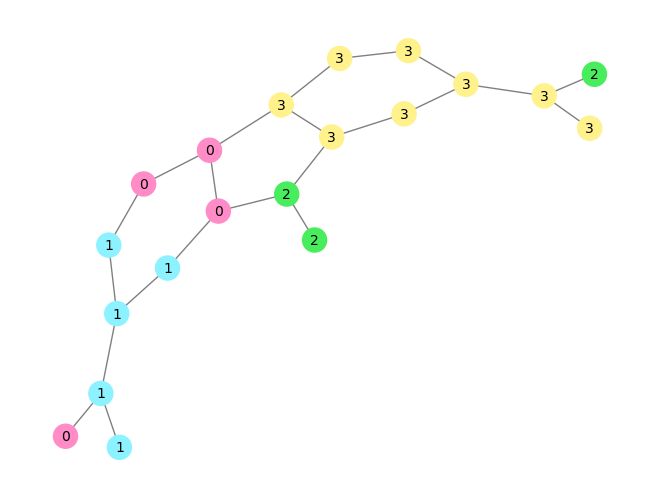

In [49]:
labels = {} 
colors = ['#FF8CC7', '#8CF2FF', '#47ED5C', '#FFF18B', '#609199', 'red','green', 'blue']
node_colors = [] #[0] * len(communities)
for i, l in enumerate(communities):
    labels[i] = str(l)
    # node_colors.append(colors[l])
pos = nx.spring_layout(G, seed=212)
for node in G.nodes():
    node_colors.append(colors[communities[node]])
    print(node, ',',communities[node])

print(node_colors)
nx.draw(G, pos=pos, node_color=node_colors, edge_color='gray')
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="black")


In [50]:
example

DataBatch(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1], batch=[20], ptr=[2])

#### Right prediction with subgraph formed

#### IMPORTANT!!
model: model-history/GIN-MUTAG/1.experiment_best_model-gin_data-mutag.pth


In [51]:
import warnings
# emb, h, S, communities, sub_emb = expe(data.x, data.edge_index, data.batch, data.ptr)import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
test_set = []
true = []
for i, data in enumerate(ts):
    # print(data)
    test_set.append(data)
    emb, h, S, communities, sub_emb, topk_indices = expe(data.x, data.edge_index, data.batch, data.ptr)
    
    print(i, h.argmax(dim=1), data.y, h.argmax(dim=1) == data.y)
    print()
    # true.append()
    if (h.argmax(dim=1) == data.y):
        true.append(i)
    # break


{0: {1: [0, 2, 3, 9, 10, 11, 12], 0: [1, 4, 5, 6, 7, 8], 2: [13, 14, 15, 16]}}
0 tensor([1]) tensor([1]) tensor([True])

{0: {2: [0, 8, 9, 10, 11], 0: [1, 2, 3, 4], 1: [5, 6, 7]}}
1 tensor([1]) tensor([0]) tensor([False])

{0: {0: [0, 1, 2, 3, 11, 12, 13], 1: [4, 5, 6, 7, 8, 9, 10], 2: [14, 15, 16, 17, 18]}}
2 tensor([1]) tensor([1]) tensor([True])

{0: {2: [0, 6, 8, 9, 10, 11, 12], 0: [1], 1: [2, 3, 4, 5, 7]}}
3 tensor([1]) tensor([0]) tensor([False])

{0: {4: [0, 4, 17, 18], 0: [1, 2, 3], 1: [5, 6, 20, 21, 22], 2: [7, 8, 16], 3: [9, 10, 11, 15], 5: [12, 13, 14, 19]}}
4 tensor([1]) tensor([1]) tensor([True])

{0: {0: [0, 8, 9, 10, 11, 13], 1: [1, 2, 3, 7], 3: [4, 5, 6, 15, 19], 2: [12, 14, 16, 17, 18]}}
5 tensor([1]) tensor([1]) tensor([True])

{0: {0: [0], 3: [1, 2, 10], 1: [3, 4, 5, 6], 2: [7, 8, 9]}}
6 tensor([1]) tensor([0]) tensor([False])

{0: {0: [0, 1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9, 10]}}
7 tensor([1]) tensor([0]) tensor([False])

{0: {0: [0, 4, 5], 2: [1, 2, 3, 13], 1

In [52]:
print('first result', len(true)/len(ts))

first result 0.6052631578947368


#### Visualize

In [59]:
def viz_graph(example):
    expe = Experiment(dataset, hidden_layer)
    # expe.load_state_dict(torch.load('model-history/GIN-MUTAG/6.experiment_best_model-gin_data-mutag.pth'))
    expe.load_state_dict(torch.load('model-history/GIN-MUTAG/1.experiment_best_model-gin_data-mutag.pth'))
    # expe.load_state_dict(torch.load('model-history/9.experiment_best_model-gin_data-mutag.pth'))
    emb, h, S, communities, sub_emb, topk_indices = expe(example.x, example.edge_index, example.batch, example.ptr)
    edge_index = example.edge_index
    G = nx.Graph()
    for start, end in zip(*edge_index):
        G.add_edge(start.item(), end.item())
        
    labels = {} 
    colors = ['#FF8CC7', '#8CF2FF', '#47ED5C', '#FFF18B', '#609199', 'red', 'blue', 'green']
    node_colors = [] #[0] * len(communities)
    for i, l in enumerate(communities):
        labels[i] = str(l)
        # node_colors.append(colors[l])
    pos = nx.spring_layout(G, seed=212)
    for node in G.nodes():
        node_colors.append(colors[communities[node]])
        # print(node, ',',communities[node])

    print("subgraph used", topk_indices)
    # print(node_colors)
    nx.draw(G, pos=pos, node_color=node_colors, edge_color='gray')
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="black")
    plt.show()

{0: {1: [0, 2, 3, 9, 10, 11, 12], 0: [1, 4, 5, 6, 7, 8], 2: [13, 14, 15, 16]}}
subgraph used tensor([1])


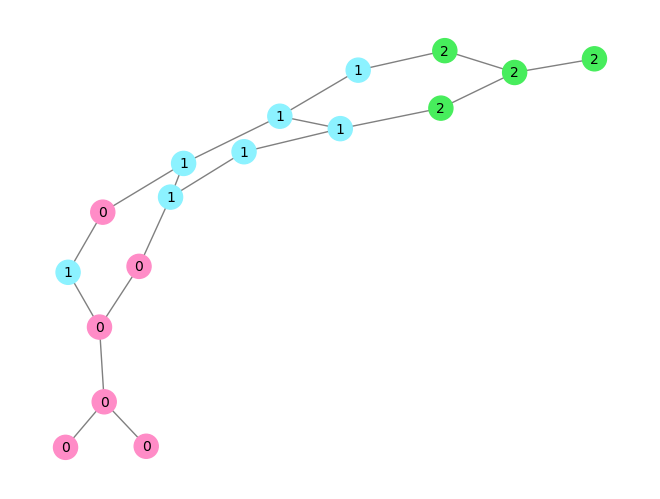

In [62]:
viz_graph(test_set[0])
# example

0
{0: {1: [0, 2, 3, 9, 10, 11, 12], 0: [1, 4, 5, 6, 7, 8], 2: [13, 14, 15, 16]}}
subgraph used tensor([1])


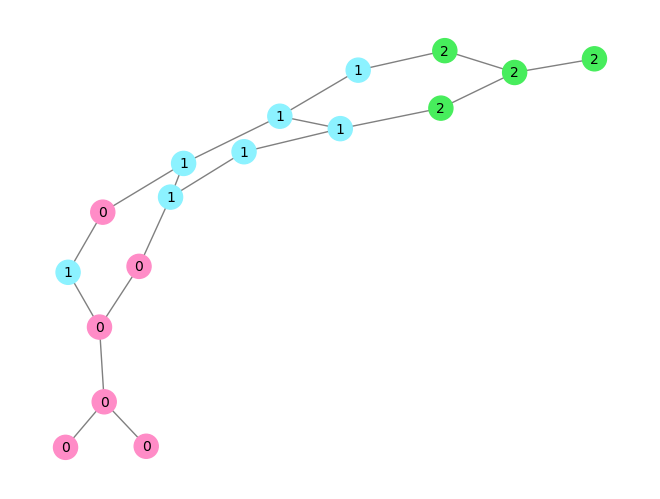

2
{0: {0: [0, 1, 2, 3, 11, 12, 13], 1: [4, 5, 6, 7, 8, 9, 10], 2: [14, 15, 16, 17, 18]}}
subgraph used tensor([2])


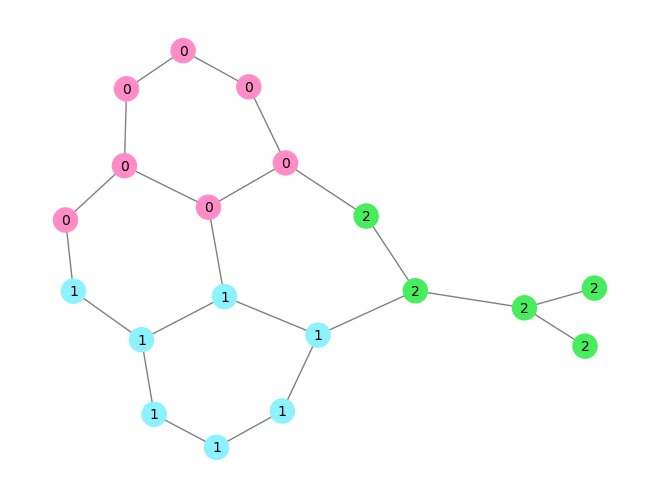

4
{0: {4: [0, 4, 17, 18], 0: [1, 2, 3], 1: [5, 6, 20, 21, 22], 2: [7, 8, 16], 3: [9, 10, 11, 15], 5: [12, 13, 14, 19]}}
subgraph used tensor([4])


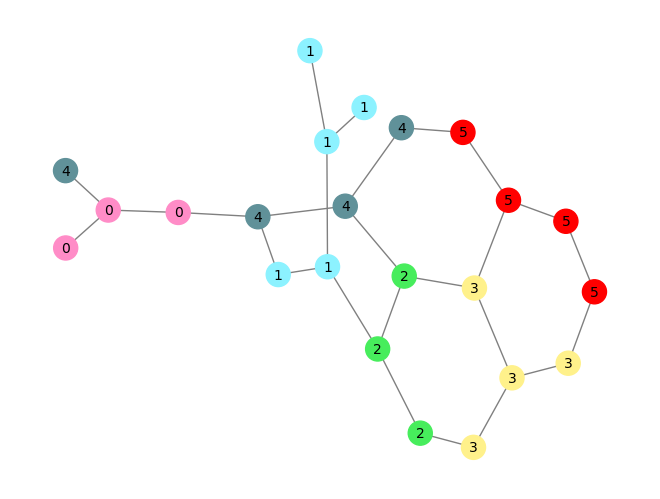

5
{0: {0: [0, 8, 9, 10, 11, 13], 1: [1, 2, 3, 7], 3: [4, 5, 6, 15, 19], 2: [12, 14, 16, 17, 18]}}
subgraph used tensor([1])


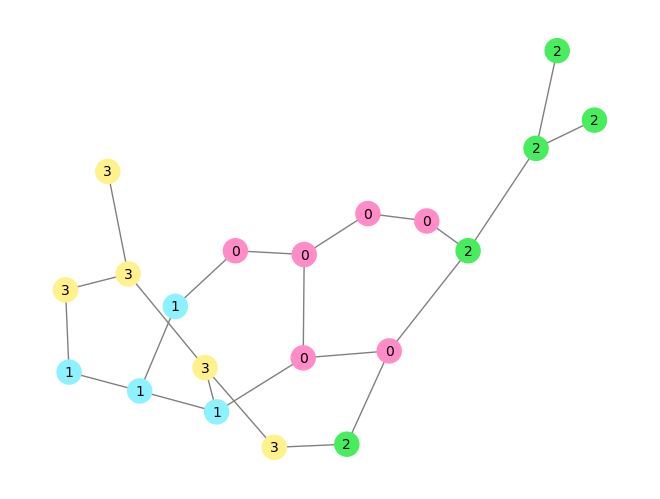

8
{0: {0: [0, 4, 5], 2: [1, 2, 3, 13], 1: [6, 7, 9, 11, 19, 25], 5: [8, 10, 23, 24], 4: [12, 17, 18], 3: [14, 15, 16, 20, 21, 22]}}
subgraph used tensor([4])


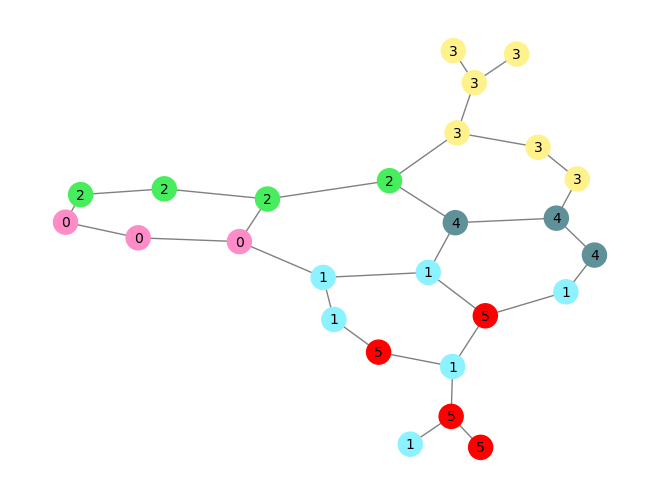

9
{0: {1: [0, 4, 5], 0: [1, 2, 3], 2: [6, 7, 14, 15, 16], 3: [8, 12, 13], 4: [9, 10, 11]}}
subgraph used tensor([4])


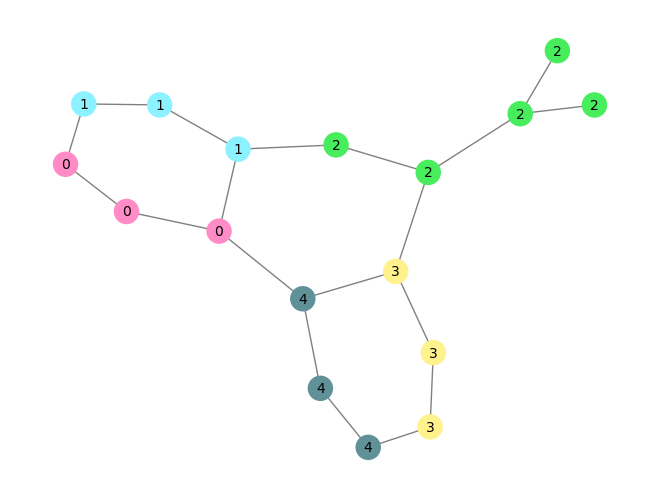

10
{0: {1: [0, 4, 5], 0: [1, 2, 3], 3: [6, 10, 11, 12, 13, 15], 2: [7, 8, 9, 19, 20, 21], 4: [14, 16, 17, 18]}}
subgraph used tensor([4])


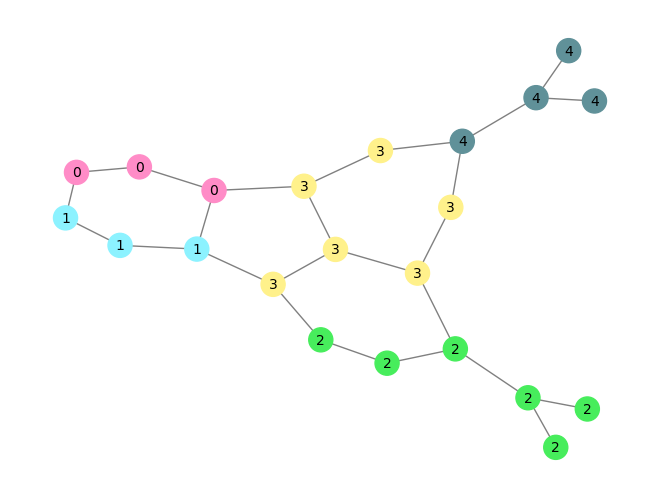

13
{0: {3: [0, 11, 12, 13, 14], 0: [1, 2, 3], 1: [4, 5, 9, 10], 2: [6, 7, 8, 15, 16, 17, 18]}}
subgraph used tensor([3])


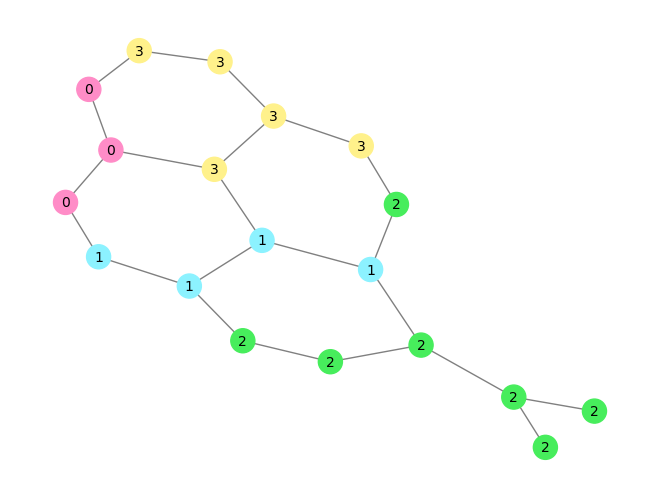

15
{0: {1: [0, 4, 5], 0: [1, 2, 3], 3: [6, 7, 8, 9, 10, 11, 19], 2: [12, 13, 14, 15, 16, 17, 18, 20, 21, 22]}}
subgraph used tensor([2])


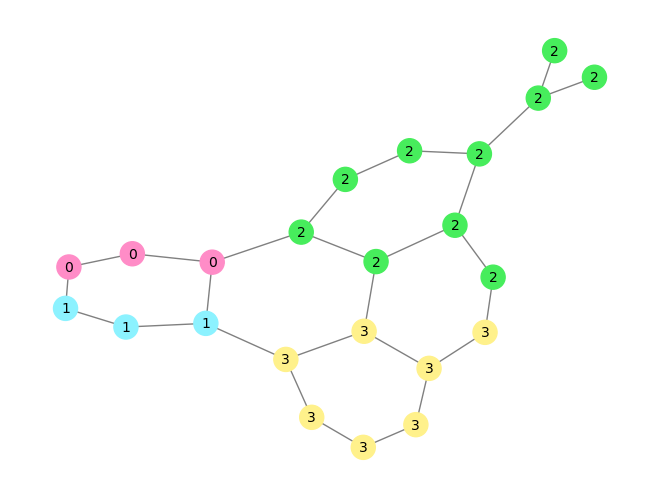

16
{0: {1: [0, 4, 5], 0: [1, 2, 3, 12], 3: [6, 7, 8, 11], 2: [9, 10], 4: [13, 14, 15, 16, 17, 18, 19]}}
subgraph used tensor([2])


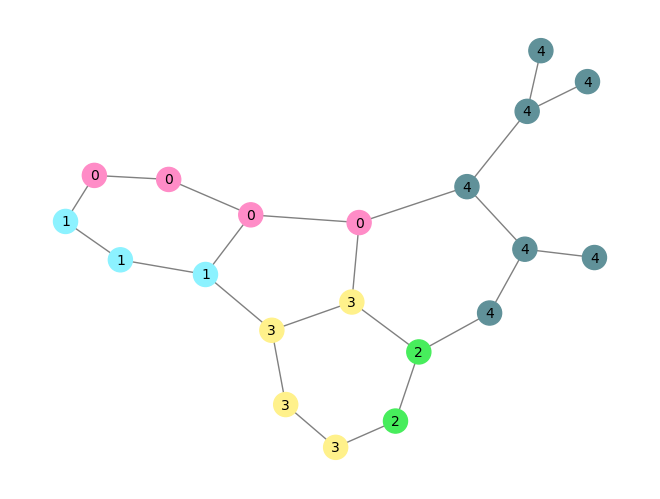

17
{0: {1: [0, 4, 5], 0: [1, 2, 3], 2: [6, 11, 12, 13], 5: [7, 16, 18], 4: [8, 9, 10, 15, 17], 3: [14, 19, 20, 21]}}
subgraph used tensor([3])


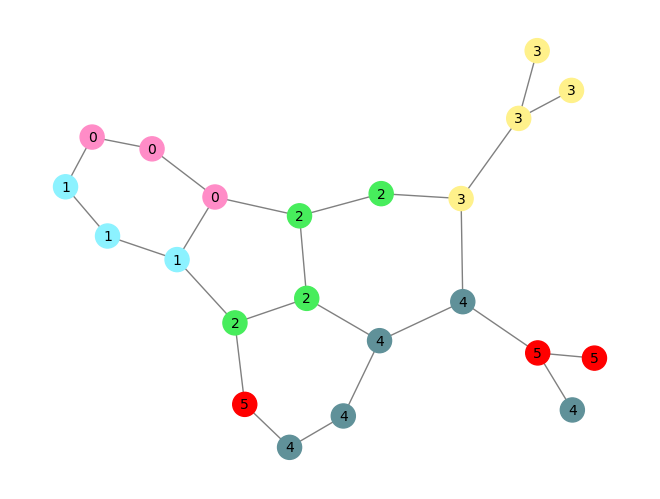

18
{0: {2: [0, 1, 2, 12], 1: [3, 9, 10, 11], 0: [4, 5, 6, 7, 8]}}
subgraph used tensor([2])


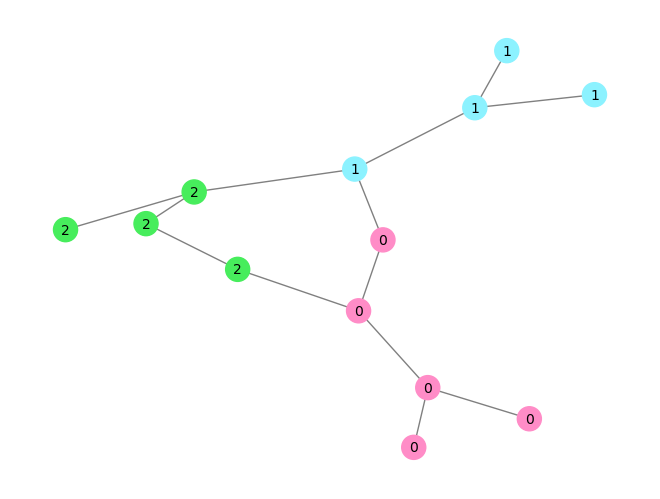

19
{0: {0: [0, 3, 4, 5, 6], 4: [1, 2, 18], 1: [7, 8], 3: [9, 10, 17], 2: [11, 12, 13, 14, 15, 16]}}
subgraph used tensor([3])


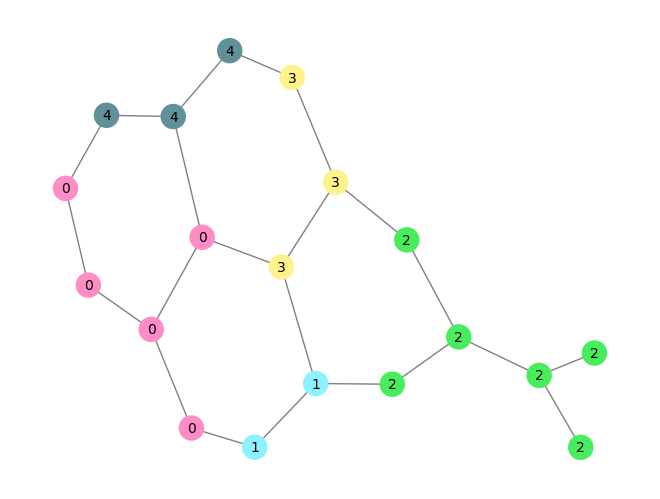

20
{0: {0: [0, 4, 5, 6, 7, 8], 1: [1, 2, 3, 9, 10, 11, 15], 2: [12, 13, 14, 16]}}
subgraph used tensor([1])


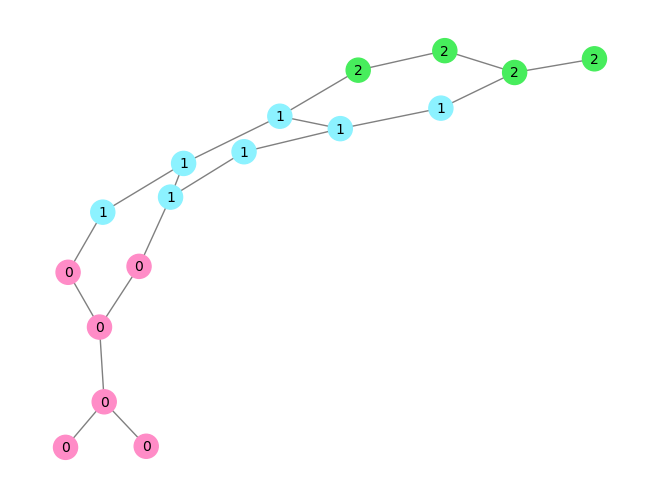

21
{0: {2: [0, 4, 5, 6, 7], 0: [1, 2, 8, 10, 11], 1: [3, 9]}}
subgraph used tensor([1])


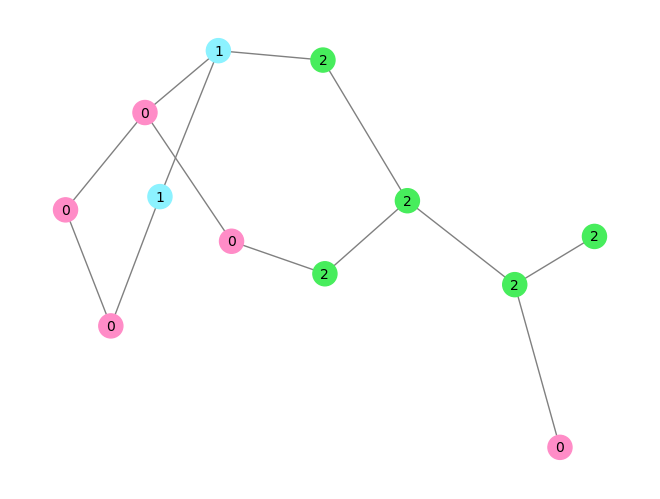

22
{0: {0: [0, 8, 9, 11, 13], 1: [1, 2, 6, 7, 15], 3: [3, 5, 19, 20], 2: [4, 21, 22], 4: [10, 12, 14, 16, 17, 18]}}
subgraph used tensor([4])


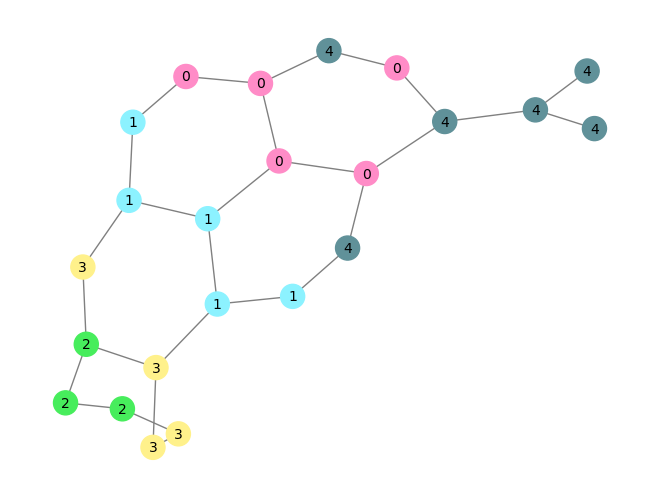

27
{0: {0: [0, 5, 6], 1: [1, 2, 3, 4, 7, 8], 2: [9, 10, 11, 12, 13, 14, 15, 16]}}
subgraph used tensor([1])


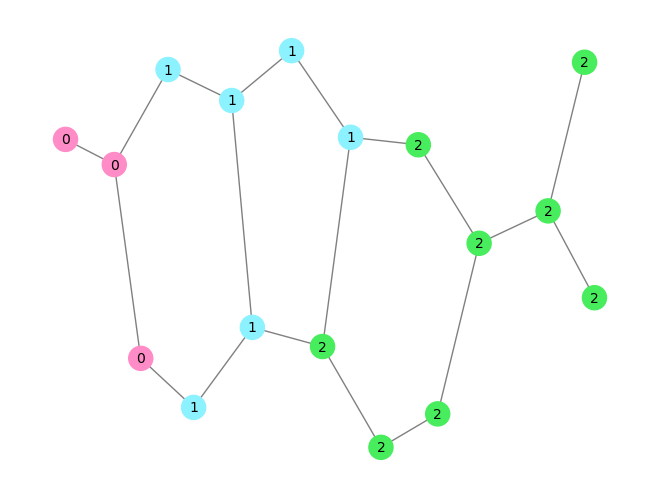

29
{0: {1: [0, 4, 5], 0: [1, 2, 3], 3: [6, 8, 10, 11, 12, 13, 14], 2: [7, 9, 19, 20, 21], 4: [15, 16, 17, 18]}}
subgraph used tensor([4])


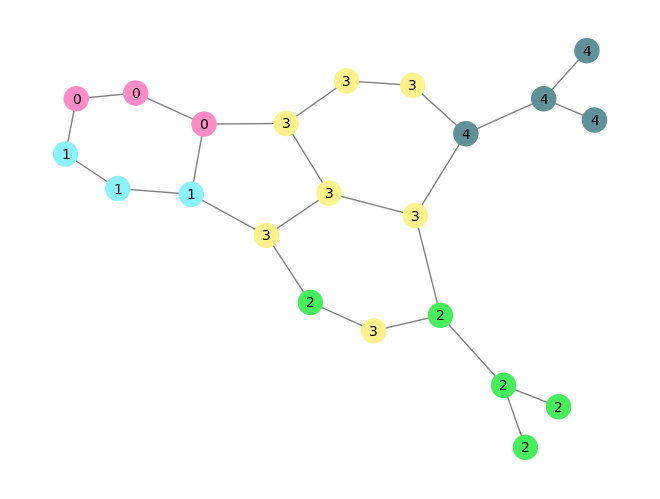

32
{0: {0: [0, 1, 2, 3, 4, 5, 15, 16, 17], 1: [6, 7, 8, 9, 10, 11, 12, 13, 14]}}
subgraph used tensor([0])


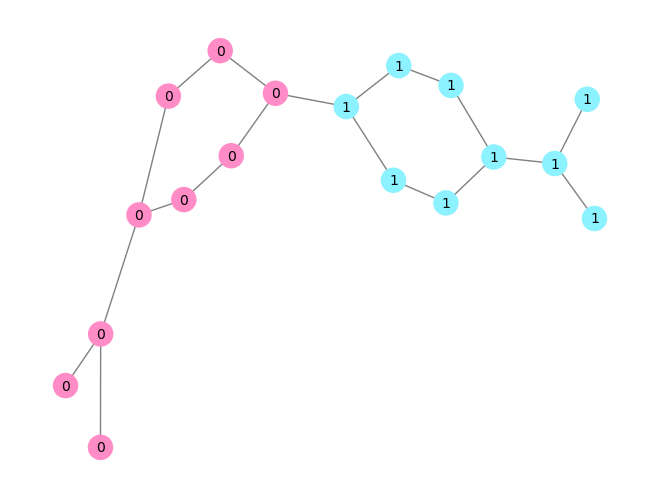

33
{0: {2: [0, 1, 7, 8, 9, 10], 0: [2, 3], 1: [4, 6, 11], 3: [5, 12, 13, 14]}}
subgraph used tensor([3])


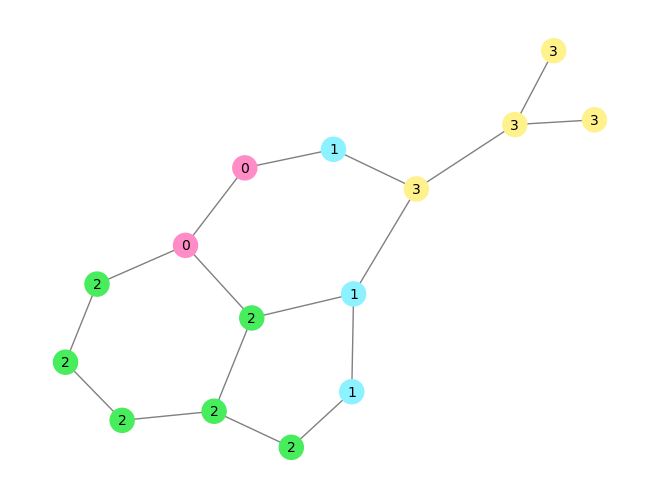

34
{0: {0: [0, 7, 8, 9, 10], 3: [1, 16, 18, 22, 24], 1: [2, 3, 4, 5], 2: [6, 11, 12, 13, 14, 15], 4: [17, 19, 20, 21, 23]}}
subgraph used tensor([1])


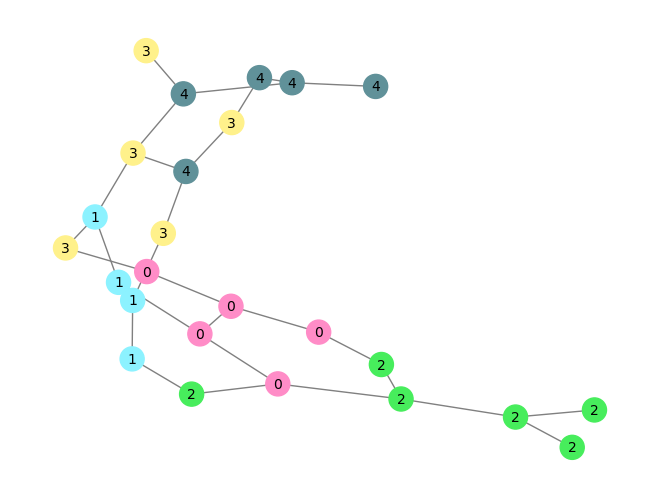

36
{0: {0: [0, 1, 2, 3, 11, 12, 13], 1: [4, 5, 9, 10], 2: [6, 7, 23, 24, 25], 3: [8, 20, 21, 22], 5: [14, 18, 19], 4: [15, 16, 17]}}
subgraph used tensor([1])


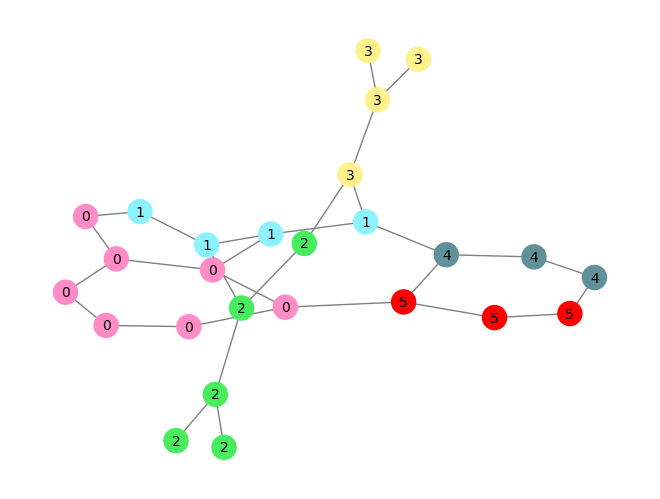

37
{0: {1: [0, 4, 5, 6, 7], 0: [1, 2, 3, 8], 2: [9, 10, 19], 3: [11, 12, 13, 14, 15, 16, 17, 18]}}
subgraph used tensor([1])


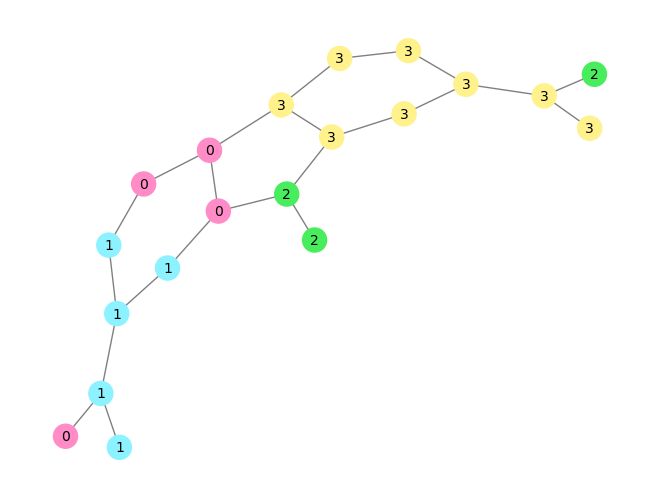

In [61]:
for i in true:
    print(i)
    viz_graph(test_set[i])

#### Molecula viz

In [40]:
node_labels = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']
test_set[0]

DataBatch(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1], batch=[23], ptr=[2])

In [43]:
def viz_graph_with_label(example):
    expe = Experiment(dataset, hidden_layer)
    expe.load_state_dict(torch.load('model-history/6.experiment_best_model-gin_data-mutag.pth'))
    # expe.load_state_dict(torch.load('model-history/GIN-MUTAG/1.experiment_best_model-gin_data-mutag.pth'))
    # expe.load_state_dict(torch.load('model-history/9.experiment_best_model-gin_data-mutag.pth'))
    node_labels = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']
    emb, h, S, communities, sub_emb, topk_indices = expe(example.x, example.edge_index, example.batch, example.ptr)
    edge_index = example.edge_index
    G = nx.Graph()
    for start, end in zip(*edge_index):
        G.add_edge(start.item(), end.item())
    labels = {} 
    colors = ['#FF8CC7', '#8CF2FF', '#47ED5C', '#FFF18B', '#609199', '#FFF','#FFA', '#FFB', '#FFC' ]
    node_colors = [] #[0] * len(communities)
    for i, l in enumerate(communities):
        labels[i] = node_labels[example.x[i].argmax().item()] + '-' + str(l)
        # labels[i] = str(l)
        # node_colors.append(colors[l])
    pos = nx.spring_layout(G, seed=212)
    for node in G.nodes():
        node_colors.append(colors[communities[node]])
        # print(node, ',',communities[node])

    print("subgraph used", topk_indices)
    # print(node_colors)
    nx.draw(G, pos=pos, node_color=node_colors, edge_color='gray')
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="black")
    plt.show()

{0: {0: [0, 8, 9, 10, 11, 13], 1: [1, 2, 6, 7, 15], 2: [3, 4, 21, 22], 3: [5, 19, 20], 4: [12, 14, 16, 17, 18]}}
subgraph used tensor([1])


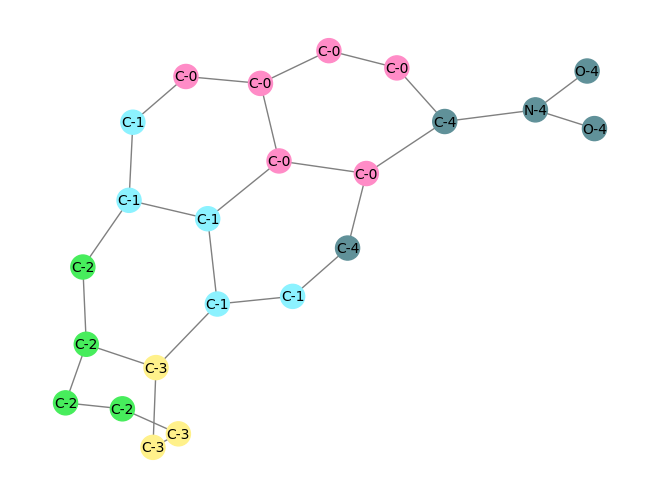

{0: {2: [0, 9], 0: [1, 2, 3, 4], 1: [5, 6, 7], 3: [8, 10, 11, 12]}}
subgraph used tensor([2])


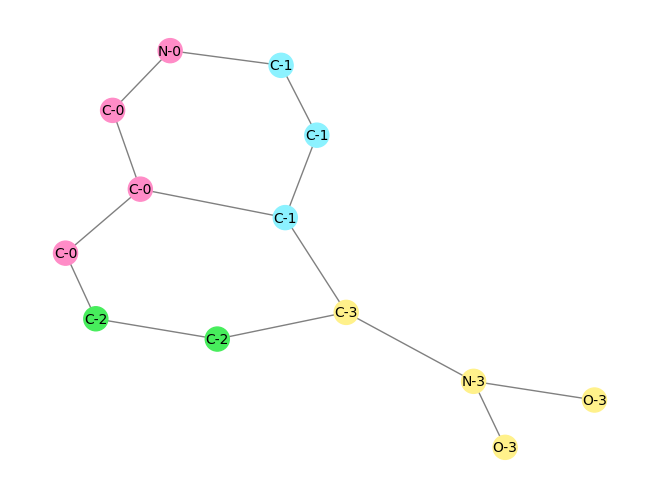

{0: {1: [0, 6, 7, 8, 9, 10, 11], 0: [1, 2, 3, 4, 5]}}
subgraph used tensor([0])


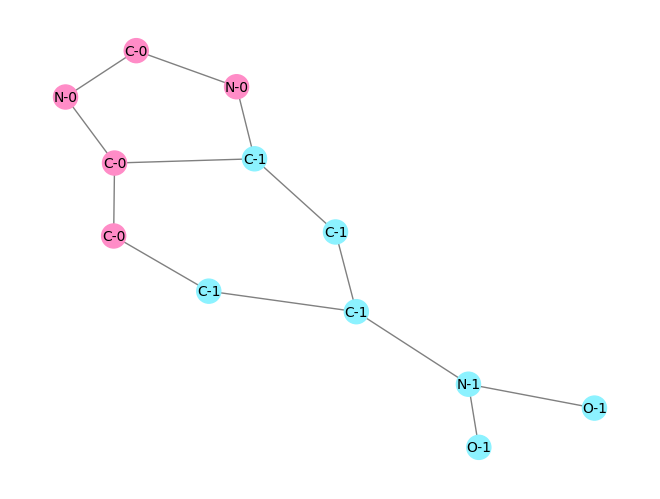

{0: {1: [0, 5, 6, 7, 8], 0: [1, 2, 3], 2: [4, 9, 10, 11, 12, 13]}}
subgraph used tensor([2])


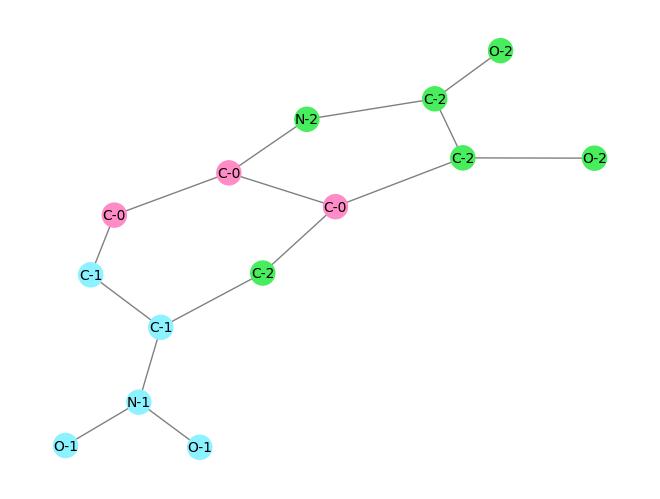

{0: {1: [0, 4, 5], 0: [1, 2, 3, 12], 3: [6, 8, 11], 2: [7, 9, 10], 4: [13, 17, 18, 19], 5: [14, 15, 16]}}
subgraph used tensor([4])


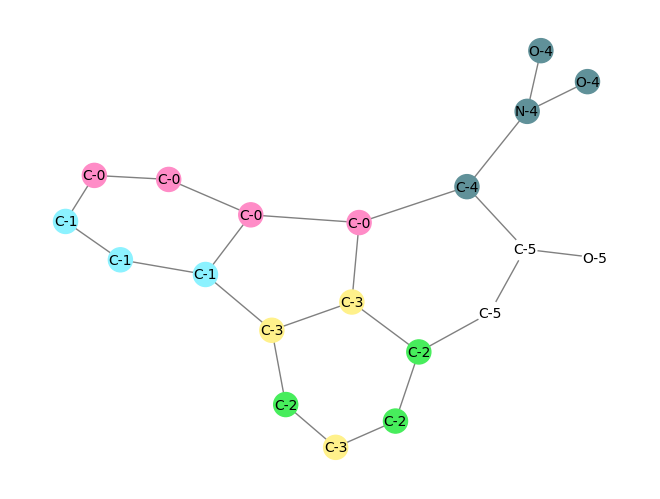

{0: {1: [0, 4, 5], 0: [1, 2, 3], 3: [6, 7, 8, 10, 11, 12, 13, 14], 2: [9, 19, 20, 21], 4: [15, 16, 17, 18]}}
subgraph used tensor([4])


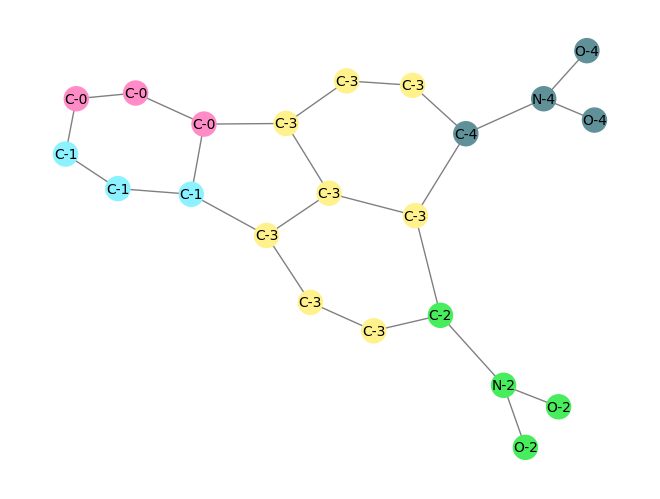

{0: {0: [0, 1, 3], 1: [2, 4, 5, 6, 7, 8, 9], 2: [10, 11, 12, 13, 14, 15]}}
subgraph used tensor([1])


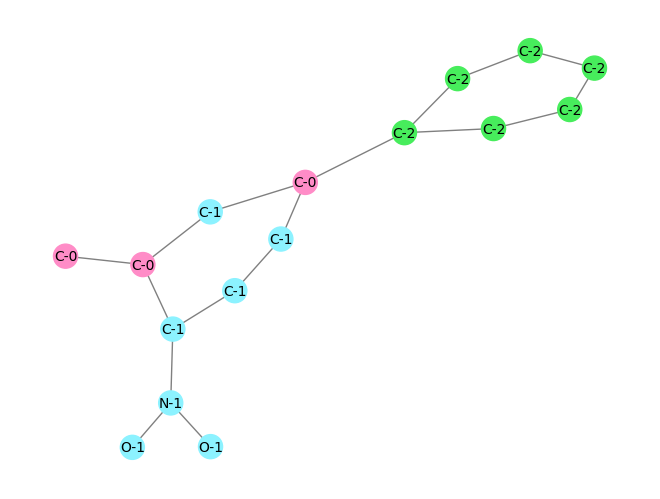

{0: {0: [0, 1, 2, 9], 1: [3, 7, 8, 12], 2: [4, 5, 6, 10, 11]}}
subgraph used tensor([1])


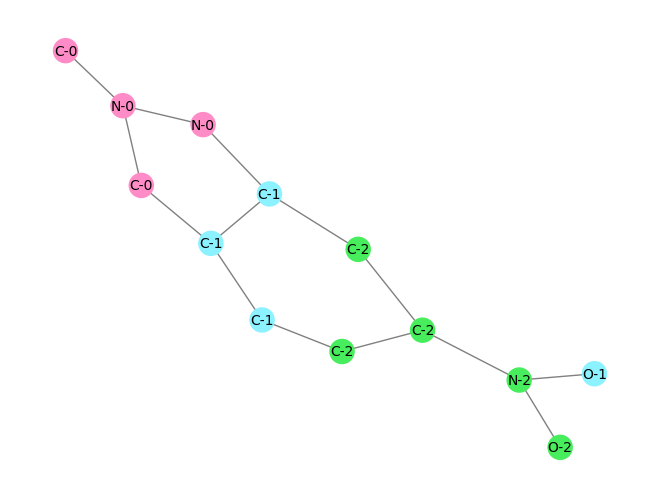

{0: {0: [0, 1, 2, 3, 4, 5, 15, 16, 17], 1: [6, 7, 8, 9, 10, 11, 12, 13, 14]}}
subgraph used tensor([0])


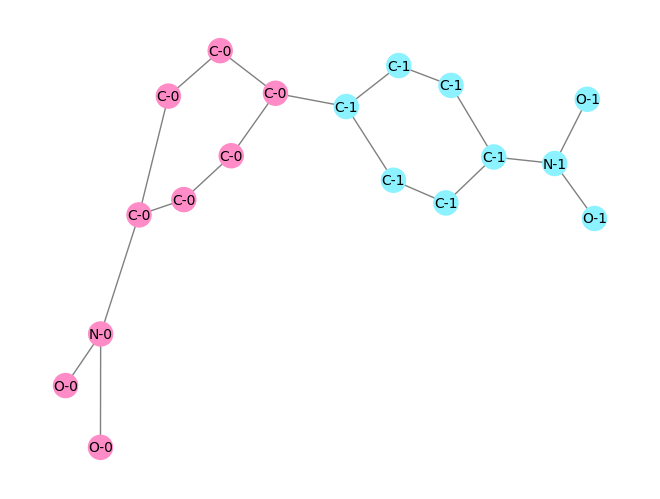

In [44]:
for data in test_set:
    viz_graph_with_label(data)

{0: {2: [0, 7, 8], 0: [1, 2, 3], 1: [4, 5, 6], 3: [9, 10, 11]}}
subgraph used tensor([0])


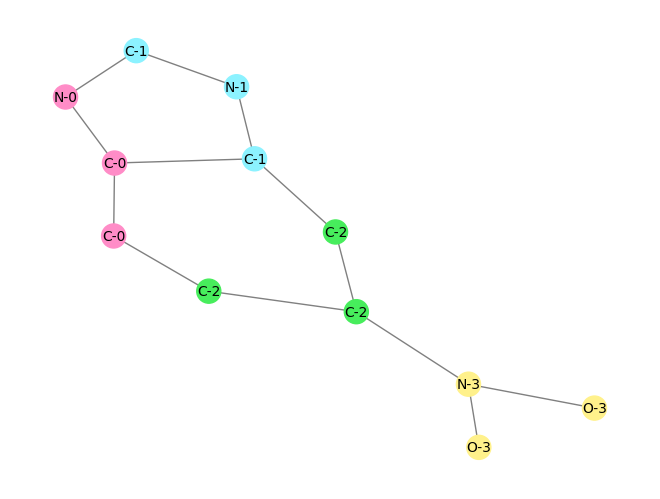

In [435]:
viz_graph_with_label(test_set[1])